## Imports

In [1]:
from ceteris_paribus.explainer import explain
from ceteris_paribus.plots.plots import plot
from ceteris_paribus.profiles import individual_variable_profile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC

import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

## Data

In [3]:
SEED = 256

In [4]:
X, y = datasets.load_wine(return_X_y=True, as_frame=True)

In [5]:
X.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [6]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [7]:
y.value_counts(normalize=True)

1    0.398876
0    0.331461
2    0.269663
Name: target, dtype: float64

In [8]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)

In [9]:
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

## EDA

In [10]:
data_train = X_train.copy()
data_train['target'] = y_train

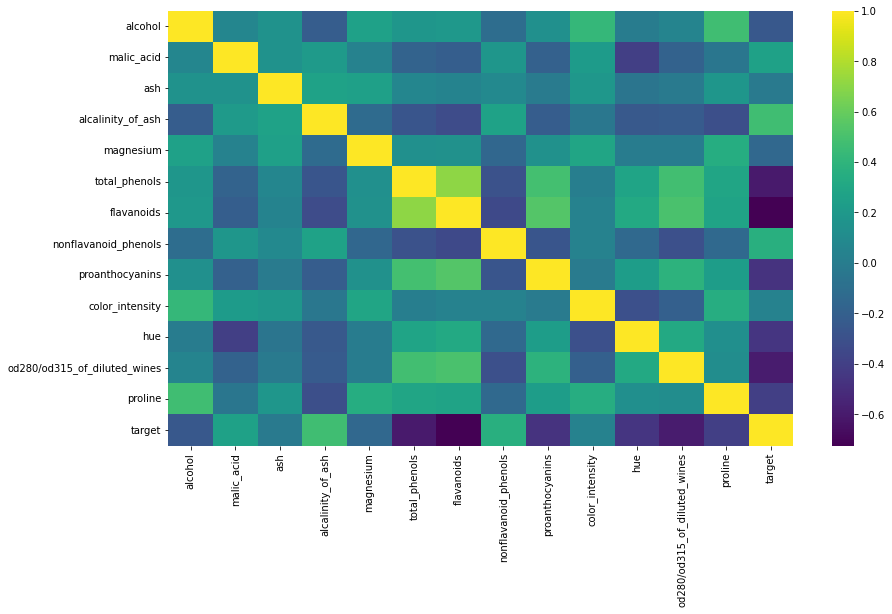

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    data_train.corr(method='kendall'), 
    ax=ax, 
    cmap='viridis',
)
plt.show()

In [12]:
correlation = data_train.corrwith(data_train['target'], method='kendall')
correlation = abs(correlation).sort_values(ascending=False)
correlation.index[1:4]

Index(['flavanoids', 'total_phenols', 'od280/od315_of_diluted_wines'], dtype='object')

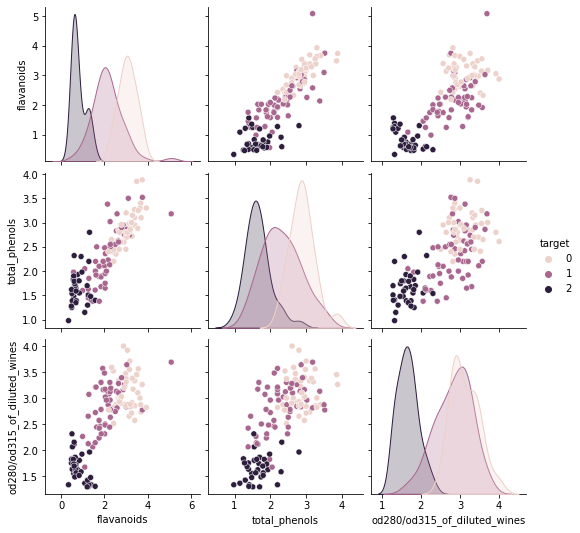

In [13]:
sns.pairplot(data_train[correlation.index[:4]], hue='target')
plt.show()

## First model

In [14]:
clf1 = GradientBoostingClassifier(
    random_state=SEED,
    verbose=True,
    learning_rate=0.5,
    n_estimators=10,
)
clf1.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.3661            0.03s
         2           0.1705            0.03s
         3           0.0852            0.02s
         4           0.0430            0.02s
         5           0.0221            0.02s
         6           0.0113            0.01s
         7           0.0058            0.01s
         8           0.0030            0.01s
         9           0.0015            0.00s
        10           0.0008            0.00s


GradientBoostingClassifier(learning_rate=0.5, n_estimators=10, random_state=256,
                           verbose=True)

In [15]:
print(f'Accuracy on train set: {clf1.score(X_train, y_train):.4f}')
print(f'Accuracy on test set: {clf1.score(X_test, y_test):.4f}')

Accuracy on train set: 1.0000
Accuracy on test set: 0.9556


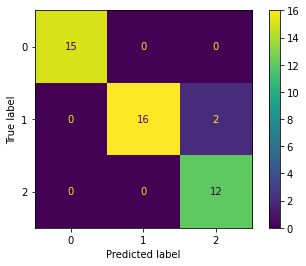

In [16]:
plot_confusion_matrix(clf1, X_test, y_test)
plt.show()

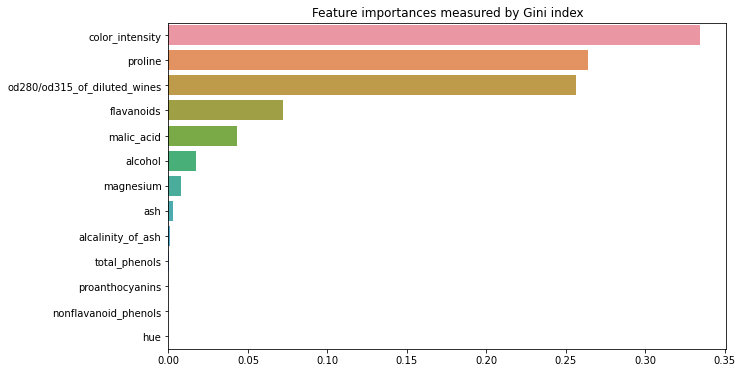

In [17]:
importances = {col: i for col, i in zip(X_train.columns, clf1.feature_importances_)}
importances = dict(sorted(importances.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(importances.values()), y=list(importances.keys()))
ax.set_title('Feature importances measured by Gini index')
plt.show()

### Explanation

In [18]:
y_pred1 = clf1.predict(X_test)

false_predictions1 = np.where(y_pred1 != y_test)[0]
print(f'Indices of incorrectly classified test examples: {false_predictions1}\n')

Indices of incorrectly classified test examples: [13 27]



In [19]:
obs1, obs2 = false_predictions1

In [20]:
explainer_rf1 = explain(clf1, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf1.predict_proba(X)[::, 0], label='class_0')
explainer_rf2 = explain(clf1, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf1.predict_proba(X)[::, 1], label='class_1')
explainer_rf3 = explain(clf1, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf1.predict_proba(X)[::, 2], label='class_2')

For explanations we will use 4 most important features (according to Gini index).

In [21]:
cp_rf1 = individual_variable_profile(explainer_rf1, X_test.iloc[obs1], y_test.iloc[obs1])
cp_rf2 = individual_variable_profile(explainer_rf2, X_test.iloc[obs1], y_test.iloc[obs1])
cp_rf3 = individual_variable_profile(explainer_rf3, X_test.iloc[obs1], y_test.iloc[obs1])

plot(cp_rf1, cp_rf2, cp_rf3, 
    selected_variables=['color_intensity', 'proline', 'od280/od315_of_diluted_wines', 'flavanoids'],
    destination='notebook')

In [22]:
cp_rf1 = individual_variable_profile(explainer_rf1, X_test.iloc[obs2], y_test.iloc[obs2])
cp_rf2 = individual_variable_profile(explainer_rf2, X_test.iloc[obs2], y_test.iloc[obs2])
cp_rf3 = individual_variable_profile(explainer_rf3, X_test.iloc[obs2], y_test.iloc[obs2])

plot(cp_rf1, cp_rf2, cp_rf3, 
    selected_variables=['color_intensity', 'proline', 'od280/od315_of_diluted_wines', 'flavanoids'],
    destination='notebook')

In [23]:
data_train[data_train['target'] == 1][['color_intensity', 'od280/od315_of_diluted_wines']].describe()

,color_intensity,od280/od315_of_diluted_wines
count,53.000000,53.000000
mean,3.061321,2.831321
std,0.805658,0.459553
min,1.740000,1.670000
25%,2.600000,2.480000
50%,2.940000,2.870000
75%,3.400000,3.160000
max,6.000000,3.690000


Observations:
* both examples are incorrectly classified as `class_2` with high probability (instead of `class_1`),
* change in flavanoids/proline does not impact model's prediction in these cases, even though proline has second largest Gini index value,
* low color intensity would change model's prediction to `class_1`,
* average or high OD ratio would result in high uncertainty (predictions for all classes would be around $\frac{1}{3}$),
* both examples have color intensity above average for `class_1`,
* both examples have OD ratio below average for `class_1`.

CP plots are roughly same for these two misclassified examples, so let's look for more variety.

In [24]:
obs3 = 0

In [25]:
cp_rf1 = individual_variable_profile(explainer_rf1, X_test.iloc[obs3], y_test.iloc[obs3])
cp_rf2 = individual_variable_profile(explainer_rf2, X_test.iloc[obs3], y_test.iloc[obs3])
cp_rf3 = individual_variable_profile(explainer_rf3, X_test.iloc[obs3], y_test.iloc[obs3])

plot(cp_rf1, cp_rf2, cp_rf3, 
    selected_variables=['color_intensity', 'proline', 'od280/od315_of_diluted_wines', 'flavanoids'],
    destination='notebook')

Observations:
* this example is correctly classified as `class_1` with high probability,
* change in OD ratio does not impact model's prediction in this case,
* average or high color intensity would result in high uncertainty (predictions for all classes would be around $\frac{1}{3}$),
* high values of proline would move predictions towards `class_0`,
* low values of flavanoids would more predictions toward `class_2`.

## Second model

In [26]:
clf2 = RandomForestClassifier(
    random_state=SEED,
)

clf2.fit(X_train, y_train)

RandomForestClassifier(random_state=256)

In [27]:
print(f'Accuracy on train set: {clf2.score(X_train, y_train):.4f}')
print(f'Accuracy on test set: {clf2.score(X_test, y_test):.4f}')

Accuracy on train set: 1.0000
Accuracy on test set: 0.9111


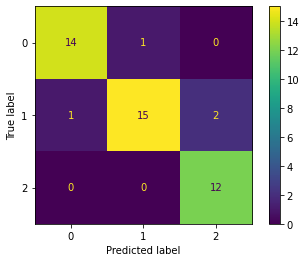

In [28]:
plot_confusion_matrix(clf2, X_test, y_test)
plt.show()

In [29]:
y_pred2 = clf2.predict(X_test)

false_predictions2 = np.where(y_pred2 != y_test)[0]
print(f'Indices of incorrectly classified test examples: {false_predictions2}\n')

Indices of incorrectly classified test examples: [13 16 27 30]



In [30]:
obs4 = false_predictions2[-1]

## Model explanation comparison

In [31]:
explainer2_rf1 = explain(clf2, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf2.predict_proba(X)[::, 0], label='class_0')
explainer2_rf2 = explain(clf2, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf2.predict_proba(X)[::, 1], label='class_1')
explainer2_rf3 = explain(clf2, X_train.columns, X_train, y_train,
                       predict_function= lambda X: clf2.predict_proba(X)[::, 2], label='class_2')

### 1st model

In [32]:
cp_rf1 = individual_variable_profile(explainer_rf1, X_test.iloc[obs4], y_test.iloc[obs4])
cp_rf2 = individual_variable_profile(explainer_rf2, X_test.iloc[obs4], y_test.iloc[obs4])
cp_rf3 = individual_variable_profile(explainer_rf3, X_test.iloc[obs4], y_test.iloc[obs4])

plot(cp_rf1, cp_rf2, cp_rf3, 
    selected_variables=['color_intensity', 'proline', 'od280/od315_of_diluted_wines', 'flavanoids'],
    destination='notebook')

### 2nd model

In [33]:
cp_rf1 = individual_variable_profile(explainer2_rf1, X_test.iloc[obs4], y_test.iloc[obs4])
cp_rf2 = individual_variable_profile(explainer2_rf2, X_test.iloc[obs4], y_test.iloc[obs4])
cp_rf3 = individual_variable_profile(explainer2_rf3, X_test.iloc[obs4], y_test.iloc[obs4])

plot(cp_rf1, cp_rf2, cp_rf3, 
    selected_variables=['color_intensity', 'proline', 'od280/od315_of_diluted_wines', 'flavanoids'],
    destination='notebook')

Comments:
* both models hesitate in between `class_0` (correct one) and `class_1`,
* for both models color intensity at inflection point between predicting `class_0` and `class_1`,
* for second model there is no change that would make `class_2` probable, while very low value of flavanoids would shift first model's prediction towards it,
* cutoffs for first model's predictions are more visible, what could be caused by a low number of used trees (only 10 estimators).